## Kaggle Rainfall Prediction

https://www.kaggle.com/c/how-much-did-it-rain-ii/overview

Rainfall is highly variable across space and time, making it notoriously tricky to measure. Rain gauges can be an effective measurement tool for a specific location, but it is impossible to have them everywhere. In order to have widespread coverage, data from weather radars is used to estimate rainfall nationwide. Unfortunately, these predictions never exactly match the measurements taken using rain gauges.

Recently, in an effort to improve their rainfall predictors, the U.S. National Weather Service upgraded their radar network to be polarimetric. These polarimetric radars are able to provide higher quality data than conventional Doppler radars because they transmit radio wave pulses with both horizontal and vertical orientations. 

Dual pulses make it easier to infer the size and type of precipitation because rain drops become flatter as they increase in size, whereas ice crystals tend to be elongated vertically.

In this competition, you are given snapshots of polarimetric radar values and asked to predict the hourly rain gauge total. A word of caution: many of the gauge values in the training dataset are implausible (gauges may get clogged, for example).

----

The training data consists of NEXRAD and MADIS data collected on 20 days between Apr and Aug 2014 over midwestern corn-growing states. Time and location information have been censored, and the data have been shuffled so that they are not ordered by time or place. The test data consists of data from the same radars and gauges over the remaining days in that month. 

To understand the data, you have to realize that there are multiple radar observations over the course of an hour, and only one gauge observation (the 'Expected'). That is why there are multiple rows with the same 'Id'.

The columns in the datasets are:

1. Id:  
    A unique number for the set of observations over an hour at a gauge.
2. minutes_past:  
    For each set of radar observations, the minutes past the top of the hour that the radar observations were carried out. Radar observations are snapshots at that point in time.
3. radardist_km:  
    Distance of gauge from the radar whose observations are being reported.
4. Ref:  
    Radar reflectivity in km
5. Ref_5x5_10th:   
    10th percentile of reflectivity values in 5x5 neighborhood around the gauge.
6. Ref_5x5_50th:   
    50th percentile
7. Ref_5x5_90th:   
    90th percentile
8. RefComposite:  
    Maximum reflectivity in the vertical column above gauge.  In dBZ.
9. RefComposite_5x5_10th
10. RefComposite_5x5_50th
11. RefComposite_5x5_90th
12. RhoHV:  
    Correlation coefficient (unitless)
13. RhoHV_5x5_10th
14. RhoHV_5x5_50th
15. RhoHV_5x5_90th
16. Zdr:    
    Differential reflectivity in dB
17. Zdr_5x5_10th
18. Zdr_5x5_50th
19. Zdr_5x5_90th
20. Kdp:  
    Specific differential phase (deg/km)
21. Kdp_5x5_10th
22. Kdp_5x5_50th
23. Kdp_5x5_90th
24. Expected:  
    Actual gauge observation in mm at the end of the hour.


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

from sklearn.linear_model import LinearRegression
lrmdl = LinearRegression()

from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_squared_error

In [12]:
pd.options.display.float_format = '{:,.4f}'.format
sns.set_style(style='darkgrid')

In [3]:
df = pd.read_csv('Rainfall-train.csv')

<bound method NDFrame.head of                Id  minutes_past  radardist_km   Ref  Ref_5x5_10th  \
0               1             3          10.0   NaN           NaN   
1               1            16          10.0   NaN           NaN   
2               1            25          10.0   NaN           NaN   
3               1            35          10.0   NaN           NaN   
4               1            45          10.0   NaN           NaN   
5               1            55          10.0   NaN           NaN   
6               2             1           2.0   9.0           5.0   
7               2             6           2.0  26.5          22.5   
8               2            11           2.0  21.5          15.5   
9               2            16           2.0  18.0          14.0   
10              2            21           2.0  24.5          16.5   
11              2            26           2.0  12.0          12.0   
12              2            31           2.0  22.5          19.0   
13  

In [ ]:
dfRef = df[['Id','minutes_past','radardist_km','Ref','Ref_5x5_10th','Ref_5x5_50th','Ref_5x5_90th','Expected']].copy()

In [65]:
dfRef1 = dfRef.fillna(value=0)

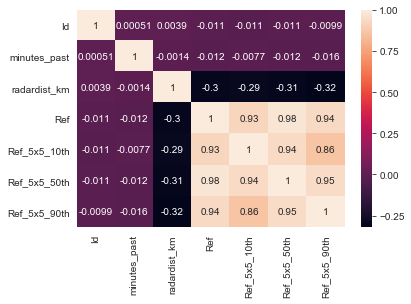

In [66]:
sns.heatmap(dfRef1.corr(), annot=True);

In [72]:
dfRef2 = dfRef[~(df.Ref.isnull() | df.Ref_5x5_10th.isnull() | df.Ref_5x5_50th.isnull() | df.Ref_5x5_90th.isnull())]

In [73]:
dfRef2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,"5,269,105.0000","588,141.6042","340,486.7939",2.0000,"290,735.0000","589,739.0000","886,510.0000","1,180,945.0000"
minutes_past,"5,269,105.0000",29.2957,17.1504,0.0000,14.0000,29.0000,44.0000,59.0000
radardist_km,"5,269,105.0000",8.9761,4.0258,0.0000,6.0000,10.0000,12.0000,21.0000
Ref,"5,269,105.0000",24.8205,9.8276,-31.0000,18.5000,24.5000,31.0000,71.0000
Ref_5x5_10th,"5,269,105.0000",19.9838,9.1951,-32.0000,14.5000,20.0000,26.0000,62.5000
Ref_5x5_50th,"5,269,105.0000",24.6899,9.2733,-29.0000,19.0000,24.5000,30.5000,69.0000
Ref_5x5_90th,"5,269,105.0000",29.8307,9.6281,-24.0000,23.5000,29.0000,36.0000,72.5000


In [74]:
dfRef2.head(50)

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th
6,2,1,2.0000,9.0000,5.0000,7.5000,10.5000
7,2,6,2.0000,26.5000,22.5000,25.5000,31.5000
8,2,11,2.0000,21.5000,15.5000,20.5000,25.0000
9,2,16,2.0000,18.0000,14.0000,17.5000,21.0000
10,2,21,2.0000,24.5000,16.5000,21.0000,24.5000
11,2,26,2.0000,12.0000,12.0000,16.0000,20.0000
12,2,31,2.0000,22.5000,19.0000,22.0000,25.0000
13,2,37,2.0000,14.0000,14.0000,18.5000,21.0000
14,2,42,2.0000,12.0000,11.0000,12.5000,17.0000
15,2,47,2.0000,1.5000,3.5000,7.0000,10.5000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13765201 entries, 0 to 13765200
Data columns (total 24 columns):
Id                       int64
minutes_past             int64
radardist_km             float64
Ref                      float64
Ref_5x5_10th             float64
Ref_5x5_50th             float64
Ref_5x5_90th             float64
RefComposite             float64
RefComposite_5x5_10th    float64
RefComposite_5x5_50th    float64
RefComposite_5x5_90th    float64
RhoHV                    float64
RhoHV_5x5_10th           float64
RhoHV_5x5_50th           float64
RhoHV_5x5_90th           float64
Zdr                      float64
Zdr_5x5_10th             float64
Zdr_5x5_50th             float64
Zdr_5x5_90th             float64
Kdp                      float64
Kdp_5x5_10th             float64
Kdp_5x5_50th             float64
Kdp_5x5_90th             float64
Expected                 float64
dtypes: float64(22), int64(2)
memory usage: 2.5 GB


In [5]:
df.isnull().sum()

Id                              0
minutes_past                    0
radardist_km                    0
Ref                       7415826
Ref_5x5_10th              8481213
Ref_5x5_50th              7408719
Ref_5x5_90th              6213920
RefComposite              7048858
RefComposite_5x5_10th     8009528
RefComposite_5x5_50th     7053538
RefComposite_5x5_90th     5935998
RhoHV                     8830285
RhoHV_5x5_10th            9632047
RhoHV_5x5_50th            8828633
RhoHV_5x5_90th            7859617
Zdr                       8830285
Zdr_5x5_10th              9632047
Zdr_5x5_50th              8828633
Zdr_5x5_90th              7859617
Kdp                       9582566
Kdp_5x5_10th             10336419
Kdp_5x5_50th              9577920
Kdp_5x5_90th              8712425
Expected                        0
dtype: int64

In [9]:
dfd = df[~(df.Ref.isnull() & df.RhoHV.isnull() & df.Zdr.isnull() & df.Kdp.isnull())].copy()

In [13]:
dfd.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,"7,214,513.0000","590,148.6009","340,378.9917",2.0000,"293,593.0000","590,944.0000","888,793.0000","1,180,945.0000"
minutes_past,"7,214,513.0000",29.3360,17.1941,0.0000,14.0000,29.0000,44.0000,59.0000
radardist_km,"7,214,513.0000",9.3661,3.9811,0.0000,7.0000,10.0000,12.0000,21.0000
Ref,"6,349,375.0000",22.9267,10.3552,-31.0000,16.0000,22.5000,29.5000,71.0000
Ref_5x5_10th,"5,276,638.0000",19.9648,9.2065,-32.0000,14.5000,20.0000,26.0000,62.5000
Ref_5x5_50th,"6,241,341.0000",22.8193,9.9975,-32.0000,16.5000,22.5000,29.5000,69.0000
Ref_5x5_90th,"6,718,771.0000",27.2980,10.7089,-28.5000,20.0000,27.0000,34.5000,72.5000
RefComposite,"6,504,295.0000",25.0920,10.5714,-32.0000,18.0000,24.5000,32.0000,92.5000
RefComposite_5x5_10th,"5,649,668.0000",22.3589,9.6437,-30.5000,16.0000,22.0000,28.5000,66.0000
RefComposite_5x5_50th,"6,418,863.0000",24.9589,10.2530,-27.5000,18.0000,24.5000,31.5000,71.0000


In [56]:
dfRef = dfd[['Id','minutes_past','Ref','Ref_5x5_10th','Ref_5x5_50th','Ref_5x5_90th']][(dfd.Ref.isnull() & ~(dfd.Ref_5x5_10th.isnull() & dfd.Ref_5x5_50th.isnull() & dfd.Ref_5x5_90th.isnull()) ) ].copy()

In [58]:
dfRef.head(25)

,Id,minutes_past,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th
302,29,11,nan,nan,nan,3.0000
369,35,22,nan,nan,nan,14.5000
370,35,28,nan,nan,nan,8.0000
374,35,53,nan,nan,nan,14.5000
409,39,26,nan,nan,nan,5.5000
411,39,45,nan,nan,1.5000,10.5000
412,39,55,nan,nan,nan,4.0000
589,58,20,nan,nan,nan,5.5000
718,69,54,nan,nan,nan,25.0000
719,69,57,nan,nan,nan,21.0000


In [14]:
dfd1 = dfd[['Id','minutes_past','radardist_km','Ref','RefComposite','RhoHV','Zdr','Kdp','Expected']].copy()
dfd1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7214513 entries, 6 to 13765200
Data columns (total 9 columns):
Id              int64
minutes_past    int64
radardist_km    float64
Ref             float64
RefComposite    float64
RhoHV           float64
Zdr             float64
Kdp             float64
Expected        float64
dtypes: float64(7), int64(2)
memory usage: 550.4 MB


In [26]:
dfd2 = pd.get_dummies(dfd1, prefix='min', columns=['minutes_past'])

In [27]:
dfd2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7214513 entries, 6 to 13765200
Data columns (total 69 columns):
Id              int64
radardist_km    float64
Ref             float64
RefComposite    float64
RhoHV           float64
Zdr             float64
Kdp             float64
Expected        float64
key             object
min_0           uint8
min_1           uint8
min_2           uint8
min_3           uint8
min_4           uint8
min_5           uint8
min_6           uint8
min_7           uint8
min_8           uint8
min_9           uint8
min_10          uint8
min_11          uint8
min_12          uint8
min_13          uint8
min_14          uint8
min_15          uint8
min_16          uint8
min_17          uint8
min_18          uint8
min_19          uint8
min_20          uint8
min_21          uint8
min_22          uint8
min_23          uint8
min_24          uint8
min_25          uint8
min_26          uint8
min_27          uint8
min_28          uint8
min_29          uint8
min_30       

In [31]:
dfd2.drop('min_0',axis=1,inplace=True)

In [33]:
dfd2.reset_index(inplace=True)

In [36]:
dfd2.drop('index',axis=1,inplace=True)

In [39]:
dfX1 = dfd2.drop(['Id','key','Expected'],axis=1)
dfy1 = dfd2[['Expected']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214513 entries, 0 to 7214512
Data columns (total 65 columns):
radardist_km    float64
Ref             float64
RefComposite    float64
RhoHV           float64
Zdr             float64
Kdp             float64
min_1           uint8
min_2           uint8
min_3           uint8
min_4           uint8
min_5           uint8
min_6           uint8
min_7           uint8
min_8           uint8
min_9           uint8
min_10          uint8
min_11          uint8
min_12          uint8
min_13          uint8
min_14          uint8
min_15          uint8
min_16          uint8
min_17          uint8
min_18          uint8
min_19          uint8
min_20          uint8
min_21          uint8
min_22          uint8
min_23          uint8
min_24          uint8
min_25          uint8
min_26          uint8
min_27          uint8
min_28          uint8
min_29          uint8
min_30          uint8
min_31          uint8
min_32          uint8
min_33          uint8
min_34          u

In [49]:
dfX1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
radardist_km,"7,214,513.0000",9.3661,3.9811,0.0000,7.0000,10.0000,12.0000,21.0000
Ref,"7,214,513.0000",20.1774,12.2411,-31.0000,12.5000,21.0000,28.5000,71.0000
RefComposite,"7,214,513.0000",22.6219,12.5153,-32.0000,15.5000,23.0000,31.0000,92.5000
RhoHV,"7,214,513.0000",0.6655,0.4585,0.0000,0.0000,0.9750,0.9983,1.0517
Zdr,"7,214,513.0000",0.3671,1.2739,-7.8750,0.0000,0.0000,0.6875,7.9375
Kdp,"7,214,513.0000",0.0206,2.9465,-96.0400,-0.3500,0.0000,0.3500,179.7500
min_1,"7,214,513.0000",0.0160,0.1253,0.0000,0.0000,0.0000,0.0000,1.0000
min_2,"7,214,513.0000",0.0167,0.1281,0.0000,0.0000,0.0000,0.0000,1.0000
min_3,"7,214,513.0000",0.0165,0.1273,0.0000,0.0000,0.0000,0.0000,1.0000
min_4,"7,214,513.0000",0.0171,0.1298,0.0000,0.0000,0.0000,0.0000,1.0000


In [48]:
dfX1.fillna(value=0, inplace=True)

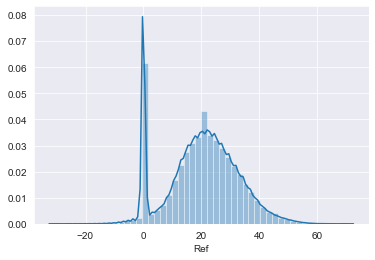

In [50]:
sns.distplot(dfX1.Ref);